# Feature Selection - 10 Different Methods

## Imports of various datasets

### Breast Cancer

from sklearn.datasets import load_breast_cancer
data_set = 'breastcancer'

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Congress

data = pd.read_csv(r'UCI/congress.csv')
data.replace('y', 1, inplace=True)
data.replace('n', 0, inplace=True)
data.replace('?', 2, inplace=True)
data.replace('republican', 1, inplace=True)
data.replace('democrat', 0, inplace=True)
X = data.drop(['Class Name'],axis=1)
y = np.ravel(data['Class Name'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Heart

data = pd.read_csv(f'UCI/heart.csv')
X = data.drop(['condition'],axis=1)
y = np.ravel(data['condition'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Ionosphere 

data = pd.read_csv(f'UCI/ionosphere.csv')  
X = data.drop(['class'],axis=1)
### Must get rid of negative values
min_values = X.iloc[:,2:].min()
### Add the minimum value of each column to all rows in that respective column
X.iloc[:,2:] += abs(min_values)
X.iloc[:,2:]
y = np.ravel(pd.get_dummies(data['class'], drop_first=True))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Sonar

data = pd.read_csv(f'UCI/sonar.csv')  
X = data.drop(['Class'],axis=1)
y = np.ravel(pd.get_dummies(data['Class'], drop_first=True))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TicTacToe

data = pd.read_csv(f'UCI/tictactoe.csv')  
data.replace('x', 1, inplace=True)
data.replace('o', 0, inplace=True)
data.replace('b', 2, inplace=True)
data.replace('positive',1, inplace=True)
data.replace('negative',0, inplace=True)
X = data.drop(['V10'],axis=1)
y = np.ravel(data['V10'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Churn

data_set = 'churn'
X_train = pd.read_csv(f'UCI/{data_set}/X_train.csv')
X_test = pd.read_csv(f'UCI/{data_set}/X_test.csv')
y_train = pd.read_csv(f'UCI/{data_set}/y_train.csv')
y_train = np.ravel(y_train)
y_test = pd.read_csv(f'UCI/{data_set}/y_test.csv')
y_test = np.ravel(y_test)

### For saving

np.savetxt("UCI/y_train.csv", y_train, delimiter=",")
np.savetxt("UCI/y_test.csv", y_test, delimiter=",")

X_train.to_csv('UCI/X_train.csv', index=False)
X_test.to_csv('UCI/X_test.csv', index=False)

## Rationale

Randomly initialized populations are cheap, but some guidance to the initial population can lead to better and faster convergence to the Pareto front

In [348]:
import pandas as pd
import numpy as np
import pygmo as pg
import random
import functools
import math as m
import copy
from numpy import genfromtxt


# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# sklearn modules
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, recall_score
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn import datasets

from sklearn.feature_selection import SelectFromModel
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import sklearn_relief as relief
from scipy.stats import spearmanr

# For ignoring warnings about bad classifiers - it's the nature of the algorithm to come across these
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import os

# Matplotlib configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 80
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)

## Declare data set and its target. Must split into train and test, else feature selection methods use test data

In [349]:
data = pd.read_csv(f'UCI/ionosphere.csv')  
X = data.drop(['class'],axis=1)
### Must get rid of negative values
# min_values = X.iloc[:,2:].min()
# ### Add the minimum value of each column to all rows in that respective column
# X.iloc[:,2:] += abs(min_values)
# X.iloc[:,2:]
y = np.ravel(pd.get_dummies(data['class'], drop_first=True))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

np.savetxt(f"UCI/{data_set}/y_train.csv", y_train, delimiter=",")
np.savetxt(f"UCI/{data_set}/y_test.csv", y_test, delimiter=",")

X_train.to_csv(f'UCI/{data_set}/X_train.csv', index=False)
X_test.to_csv(f'UCI/{data_set}/X_test.csv', index=False)

### X must be a pandas dataframe with the features as columns, y must be a flat numpy array

## Models to run on

In [350]:
# Set of learning algorithms
model_dict = {
    "SVC lin": SVC(random_state=42,kernel='linear',max_iter=int(1e4)),
    "SVC rbf": SVC(random_state=42,kernel='rbf',max_iter=int(1e4)),
    "Log lasso": LogisticRegression(random_state=42,penalty='l1', solver = 'liblinear'),
    "Log ridge": LogisticRegression(random_state=42,penalty='l2'),
    "Dec tree": DecisionTreeClassifier(random_state=42),
    "Grad boost": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    "Rand forest": RandomForestClassifier(max_depth=2, random_state=42)
}

### Some feature selection methods only take metric data as an input, we distinguish their keys here

In [351]:
# Number of features in model
total_features = int(X_train.shape[1])

# Feature names
feat_names = np.asarray(list(X_train.columns))

# Make list of indices of all features
feat_indices = np.asarray(list(range(total_features)))

In [352]:
# Make dictionary of indices of all features, for easy lookup
feat_dictionary = {}

for i, feature in enumerate(feat_names):
    
    feat_dictionary[feature] = i

# Wrapper Methods

Wrapper methods use supervised learning for selecting the optimal feature subset. They use classifiers to gauge the classification performance of the selected feature subset in every iteration. This leads to an increased computational cost than filter-based methods, but such methods also perform several times better.

##  Recursive Feature Elimination (RFE)

RFE selects top k features based on the machine learning model that has coef_attribute or feature_importances_attribute from their model (Almost any model). RFE would eliminate the least important features then retrain the model until it only selects the K-features you want.

(IMPORTANT!) This method only works if the model has coef_ or features_importances_ attribute, if there are models out there having these attributes, you could apply RFE on Scikit-Learn.

In [353]:
def recursive_feature_elimination(model_name,k):
    '''
    Employs the recursive feature elemination scikit-learn module to get the top k features in the training matrix
    '''

    # Selecting the best important features according to Logistic Regression
    rfe_selector = RFE(estimator=model_dict[model_name], n_features_to_select = k, step = 1)

    rfe_selector.fit(X_train, y_train)

    return feat_indices[rfe_selector.get_support().tolist()]

##  Feature Selection via SelectFromModel - returns many features

Like the RFE, SelectFromModel from Scikit-Learn is based on a Machine Learning Model estimation for selecting the features. The differences are that SelectFromModel feature selection is based on the importance attribute (often is coef_ or feature_importances_ but it could be any callable) threshold. By default, the threshold is the mean.

SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_) or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter. Apart from specifying the threshold numerically, there are built-in heuristics for finding a threshold using a string argument. Available heuristics are “mean”, “median” and float multiples of these like “0.1*mean”. In combination with the threshold criteria, one can use the max_features parameter to set a limit on the number of features to select.

In [354]:
def select_from_model(model_name, k):
    '''
    For a given learning algorithm, get features that pass the mean threshold in the training matrix
    '''

    sfm_selector = SelectFromModel(estimator=model_dict[model_name], max_features=k)

    sfm_selector.fit(X_train, y_train)
    
    features = np.asarray(feat_indices[sfm_selector.get_support().tolist()])
    
    # For handling missing values
    if len(features) < k:
        
        # Get values not in the list
        missing = feat_indices[~np.in1d(feat_indices, features)]
        
        # Get the number of missing features you need to add to output k
        num_missing = k - len(features)
        
        return np.append(features, missing[:num_missing])
    
    # Add feature indices to list
    return features


# Filter Methods

Filter-based feature selection methods determine feature importance using several scoring metrics in an unsupervised fashion, requiring no classifiers in its core. 

## Univariate Feature Selection with SelectKBest 

Univariate Feature Selection is a feature selection method based on the univariate statistical test, e,g: chi2, Pearson-correlation, and many more. The first test below is done using the ANOVA F-value between label/feature for classification tasks.

The premise with SelectKBest is combining the univariate statistical test with selecting the K-number of features based on the statistical result between the X and y.

In [355]:
def selectkbest_ANOVA(k):
    '''
    Use analysis of variance to return k best features in the training matrix
    '''
    
    ANOVA_selector = SelectKBest(k=k)

    ANOVA_selector.fit(X_train, y_train)
    
    return feat_indices[ANOVA_selector.get_support().tolist()]

## SelectKBest - Mutual Information

From documentation: Mutual information (MI) [1] between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances as described in [2] and [3]. Both methods are based on the idea originally proposed in [4].


In [356]:
def selectkbest_mutual_inf(k):
    '''
    Use the muutal information of features to get the relative importance of k best features in the training matrix
    '''
    
    MI_selector = SelectKBest(mutual_info_classif, k=k)

    MI_selector.fit(X_train, y_train)
    
    return feat_indices[MI_selector.get_support().tolist()]

## SelectKBest - ChiSquare

The higher the value of the X2
f metric, the higher is the importance of the feature f. The Chi-square measure is robust to
the distribution of the data, can be computed with ease (i.e. low
computational cost), and can capture detailed information from
the data. The drawback of the method is that it is unable to interpret data classified into a large number of categories.

In [357]:
def selectkbest_chi2(k):
    '''
    Rank features according to chi-2 values - cannot accept negative feature values
    '''
    
    chi2_selector = SelectKBest(score_func=chi2, k=k)

    chi2_selector.fit(X_train, y_train)
    
    return np.asarray(feat_indices[chi2_selector.get_support().tolist()])


## Pearson Correlation Coefficient

A lower value of PCCx indicates higher importance of the feature x. PCC can quantify the correlation between attributes in
the feature space since it uses the method of covariance. It measures both the magnitude and direction of association between
the features.

In [358]:
def pearson_corr_select(k):
    '''
    Rank features according to pearson correlation co-efficient
    '''

    # Get correlations
    correlation_matrix = np.corrcoef(X_train, y_train, rowvar=False)
    
    # Extract the correlation coefficients of each feature with the target (last column)
    correlations_with_target = correlation_matrix[:-1, -1]
    
    # Sort the indices of the features based on the correlation coefficients in descending order
    sorted_indices = np.argsort(correlations_with_target)[::-1]
    
    return sorted_indices[:k]

## Spearman's Correlation Co-efficient

Spearman's rank correlation coefficient is a useful method for assessing feature importance in scenarios where the relationships between features and the response variable are not strictly linear and might involve monotonic, but not necessarily linear, trends. Unlike linear correlation measures, such as Pearson's correlation, Spearman's rank takes into account the relative order of values rather than their precise numerical differences. This makes it effective in capturing nonlinear associations and identifying features that impact the response variable in consistent monotonic ways. It is particularly valuable when dealing with ordinal or categorical data, or when the relationships involve outliers that can distort linear correlations. Spearman's rank offers a more comprehensive view of feature importance by considering both the direction and strength of monotonic relationships, making it suitable for a broader range of data distributions and relationships. This code is taken from the HFMOEA paper, (Kundu, Mallipedi).

In [359]:

def spearman_feature_importance(X, y):
    '''
    Use spearman rank to get feature importance of all features in data matrix
    '''
    
    X = X.values
    
    num_features = X.shape[1]
    feature_importance_scores = np.zeros(num_features)
    
    # Get spearman rank for each feature
    for i in range(num_features):
        feature_scores, _ = spearmanr(X[:, i], y)
        feature_importance_scores[i] = abs(feature_scores)
            
    return np.argsort(feature_importance_scores)



## Mean Absolute Deviation

The mean absolute difference (MAD) computes the absolute difference from the mean value. The main difference between the variance and MAD measures is the absence of the square in the latter. The MAD, like the variance, is also a scale variant.’ [1] This means that higher the MAD, higher the discriminatory power.

In [360]:
def mean_abs_deviation(k):
    '''
    Get k best features using mean absolute deviation
    '''
    # Calculate MAD for each feature
    mean_abs_diff = np.sum(np.abs(X_train - np.mean(X_train,axis=0)),axis=0)/X_train.shape[0]

    # Sort by decreasing values of MAD, get the k best features
    l = mean_abs_diff.to_frame().sort_values(by=[0], ascending=False)
    k_best_strings = list(l.index[:k])

    return np.asarray([feat_dictionary[el] for el in k_best_strings])

## Fisher Score - metric vars only

Input only metric features. Fisher score is one of the most widely used supervised feature selection methods. The algorithm which we will use returns the ranks of the variables based on the fisher’s score in descending order. We can then select the variables as per the case.

In [361]:
def fisher_score_func(k):
    '''
    Select best k features using fisher score
    '''
    # Use the Fisher algorithm to get a score for each metric feature
    ranks = fisher_score.fisher_score(X_train.values,y_train)
    
    return np.asarray(ranks[:k])
    

## Relief Filter

A
similarity-based metric that computes the Euclidean distance to
assert feature importance. For this, a feature X is selected randomly, and its two nearest neighbors, based on the Euclidean
distance, are selected as such: one from the same class as X, represented as H, called nearest hit, and the other neighbor from a
different class, represented as M, called nearest miss. 

The Relief filter methods do not assume conditional independence of the features in the feature space to estimate their
importance, unlike many heuristic algorithms. Relief is an efficient algorithm that can capture contextual information and
assess the attribute quality in cases where there are strong dependences between the attributes.

In [362]:
def Relief(k):
    '''
    Use relief algorithm to get feature rankings for k top features
    '''

    r = relief.Relief(
        n_features=total_features
    ) 

    my_transformed_matrix = r.fit_transform(
        X_train.values,
        y_train
    )

    # Higher weights are better
    weights = np.zeros((total_features ,2))

    weights[:,0], weights[:,1] = np.asarray(r.w_), feat_indices

    weights_sort = weights[weights[:, 0].argsort()[::-1]]

    return np.asarray(weights_sort[:k,1].astype(int))

# Building a Borda voting system

### Declare model name to run for

In [363]:
model_name = 'Log lasso'

### Method names

In [364]:
method_names = ['PCC', 'MAD', 'Fisher', 'Relief', 'RFE', 'SFM', 'ANOVA', 'MI', 'Chi-2']

### Check if every function returns the right amount of features

k = total_features
elements_list = [
    pearson_corr_select(k),
    mean_abs_deviation(k),
    fisher_score_func(k),
    Relief(k),
    recursive_feature_elimination(model_name, k),
    select_from_model(model_name, k),
    selectkbest_ANOVA(k),
    selectkbest_mutual_inf(k),
    selectkbest_chi2(k)
]

print("Missing features in each method are as follows:")
for i, el in enumerate(elements_list):
    
    missing = len(feat_indices[~np.in1d(feat_indices, el)])
    
    if missing > 0:
        print(f"Method {method_names[i]} has {missing} missing features")

# Methods that return ranked lists

### A function that returns the best features from feature selection methods that rank their outputs

For example, the relief algorithm does return a score for each feature, allowing for very easy ranking. But some selection methods return only the k features they selected in numerical order. So in order to get a ranking from every one, this process is used

In [365]:
def get_ranked_features():
    '''
    This function returns a ranked list of features from all the methods listed in it
    '''
    
    features = []
    k = total_features
    
    features.append(spearman_feature_importance(X_train,y_train))
    features.append(pearson_corr_select(k))
    features.append(mean_abs_deviation(k))
    features.append(fisher_score_func(k))
    features.append(Relief(k))
    
    return np.asarray(features)

# Methods that don't return ranked lists

### A function that returns the best features from feature selection methods that don't rank their outputs

In [366]:
def get_features_for_k(k, model_name):
    '''
    Used recursively with incremented k to build a ranking list for feature selection methods that don't
    return featuers in order they are ranked in
    '''
    
    features=[]
    try:
        features.append(recursive_feature_elimination(model_name,k))
        features.append(select_from_model(model_name, k))
        features.append(selectkbest_ANOVA(k))
        features.append(selectkbest_mutual_inf(k))
        features.append(selectkbest_chi2(k))
    
    except ValueError:
        features.append(recursive_feature_elimination(model_name,k))
        features.append(select_from_model(model_name, k))
        features.append(selectkbest_ANOVA(k))
        features.append(selectkbest_mutual_inf(k))

    return np.asarray(features)

### A function to append only the unique features output by each iteration of k to the matrix of features

In [367]:
def add_unique_elements_column(matrix1, matrix2):
    '''
    Adds unique feature indices found with each iteration of k to the rankings matrix
    '''
    # Initialize an empty array to store the new column
    new_column = np.empty((matrix1.shape[0], 1), dtype=matrix1.dtype)

    # Iterate through the rows of both matrices
    for i in range(matrix1.shape[0]):
        # Find the unique elements in the corresponding row of matrix2
        unique_elements = np.setdiff1d(matrix2[i], matrix1[i])

        # Add the first unique element to the new column
        new_column[i, 0] = unique_elements[0]

    # Concatenate the new column to matrix1
    result_matrix = np.hstack((matrix1, new_column))

    return result_matrix

### A function that combines the above two to produce a matrix of features, where each method represents a row and each column represents a ranking of the features, with an index of 0 being best

In [368]:
def get_feature_matrix():
    '''
    Calls all function necessary to build feature matrix
    '''
    
    ranked = get_ranked_features()
    
    output = get_features_for_k(1, model_name)
    
    for k in range(2,total_features+1):
    
        matrix2 = get_features_for_k(k, model_name)

        output = add_unique_elements_column(output, matrix2)

    return np.vstack((ranked, output))

In [369]:
rankings_matrix = get_feature_matrix()

/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarn

/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariat

/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariat

/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/feature_selection/_univariat

## Calculating and plotting Borda scores

In [370]:
def calculate_borda_scores(rankings_matrix, weights=None):
    '''
    I: ranking matrix from get_feature_matrix
    I (optional) weights, array of floats from zero to one, represent the voting weight that particular feature selection method has
    O: borda scores for all features in the data matrix
    '''
    num_features = len(rankings_matrix[0])
    num_methods = len(rankings_matrix)
    borda_scores = np.zeros(num_features)

    if weights is None:
        weights = np.ones(num_methods)

    if len(weights) != num_methods:
        raise ValueError("The number of weights must be equal to the number of methods.")

    for i, method_rankings in enumerate(rankings_matrix):
        try:
            # Calculate the scores for each feature based on its ranking in the method and apply weights
            scores = weights[i] * (num_features - np.array(method_rankings))
            borda_scores += scores
        except ValueError as e:
            print("Error:", e)
            print("Ensure that all feature rankings have the same number of features.")
            return None

    return borda_scores

In [371]:
weights = [0.31412219, 0.86978109, 0.02877184, 0.25149087, 0.05472679,
       0.77189679, 0.7694783 , 0.94683922, 0.41915218, 0.0572985 ]

In [372]:
# Calculate the Borda count scores for each feature
borda_scores = calculate_borda_scores(rankings_matrix, None)

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    "Feature Index": range(len(borda_scores)),
    "Borda Score": [int(score) for score in borda_scores],
    "Feature Name": [feat_names[i] for i in range(len(borda_scores))]
})

# Sort the DataFrame based on the Borda scores in descending order
results_df = results_df.sort_values(by="Borda Score", ascending=False)

# Display the first ten scores
results_df.head(10)

,Feature Index,Borda Score,Feature Name
11,11,320,a12
2,2,315,a03
0,0,310,a01
18,18,288,a19
33,33,281,a34
14,14,277,a15
19,19,260,a20
3,3,258,a04
1,1,255,a02
5,5,253,a06


### For saving things

np.savetxt("rankings_matrix.csv", rankings_matrix, delimiter=",")

results_df.to_csv('borda_scores.csv', index=False)

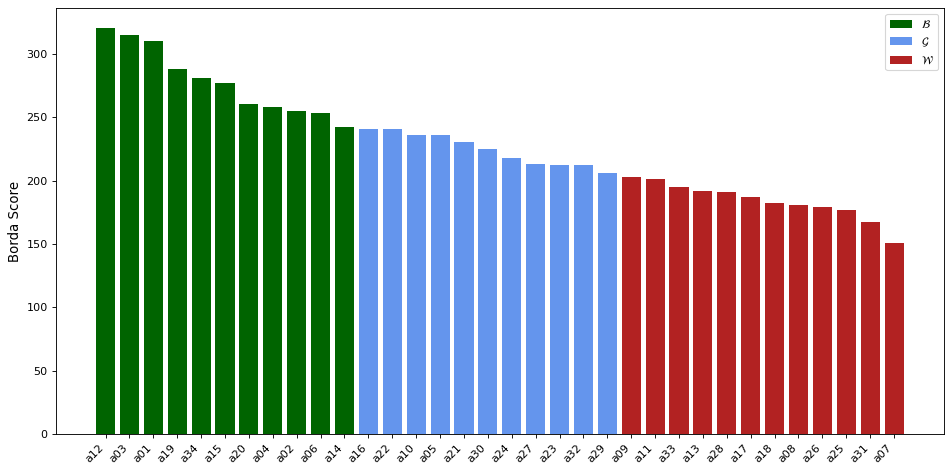

In [373]:
# Assuming you have a DataFrame called 'df' with columns 'Feature Index', 'Borda Score', and 'Feature Name'
# Sort the DataFrame by 'Borda Score' in descending order
df_sorted = results_df.sort_values(by='Borda Score', ascending=False)

# Partition the features into 3 sets based on the sorted Borda scores
num_features = len(df_sorted)
num_features_per_set = num_features // 3
set1 = df_sorted.iloc[:num_features_per_set]
set2 = df_sorted.iloc[num_features_per_set:2*num_features_per_set]
set3 = df_sorted.iloc[2*num_features_per_set:]

# Create the bar plot with different colors for each set
plt.figure(figsize=(12, 6))  # Adjust the figure size as per your requirement

plt.bar(set1['Feature Name'], set1['Borda Score'], color='darkgreen', label='$\mathcal{B}$')
plt.bar(set2['Feature Name'], set2['Borda Score'], color='cornflowerblue', label='$\mathcal{G}$')
plt.bar(set3['Feature Name'], set3['Borda Score'], color='firebrick', label='$\mathcal{W}$')

# Set x-axis labels with rotation for better visibility
plt.xticks(rotation=45, ha='right')

# Set axis labels and title
plt.ylabel('Borda Score')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()

plt.savefig(f"borda_scores_vodafone.pdf", bbox_inches='tight', format="pdf", dpi=1200)
plt.show()


## Partition Borda scores, save as numpy arrays

In [374]:
def partition_borda_scores(borda_scores):
    '''
    Partitions feature set into three equal sets based on Borda scores
    '''
    # Get the feature indices sorted based on Borda scores (in descending order)
    sorted_indices = sorted(range(len(borda_scores)), key=lambda x: borda_scores[x], reverse=True)

    # Calculate the size of each set (best, good, worst) to achieve roughly equal partitions
    set_size = len(sorted_indices) // 3
    remaining = len(sorted_indices) % 3

    # Partition the indices into three sets
    best_features = sorted_indices[:set_size + remaining]
    good_features = sorted_indices[set_size + remaining: 2 * (set_size + remaining)]
    worst_features = sorted_indices[2 * (set_size + remaining):]

    psi = [best_features,good_features,worst_features]

    ordered = [np.unique(feat_set) for feat_set in psi]

    return ordered[0], ordered[1], ordered[2]

In [375]:
best_features, good_features, worst_features = partition_borda_scores(borda_scores)

In [376]:
# Get indices in order

psi = [best_features,good_features,worst_features]

ordered = [np.unique(feat_set) for feat_set in psi]
    
np.savetxt(f"UCI/{data_set}/best.csv", ordered[0], delimiter=",")
np.savetxt(f"UCI/{data_set}/good.csv", ordered[1], delimiter=",")
np.savetxt(f"UCI/{data_set}/worst.csv", ordered[2], delimiter=",")

## Showing all partitions

In [377]:
print(f"This workbook found this many best features: {len(best_features)} \n")
print(f"These are the indices of the best features: {list(best_features)} \n")
print(f"These are the feature names of the best features: {feat_names[best_features]}")


This workbook found this many best features: 12 

These are the indices of the best features: [0, 1, 2, 3, 5, 11, 13, 14, 15, 18, 19, 33] 

These are the feature names of the best features: ['a01' 'a02' 'a03' 'a04' 'a06' 'a12' 'a14' 'a15' 'a16' 'a19' 'a20' 'a34']


In [378]:
print(f"This workbook found this many unique good features: {len(good_features)} \n")
print(f"These are the indices of the good features: {good_features} \n")
print(f"These are the feature names of the good features: {feat_names[good_features]}")


This workbook found this many unique good features: 12 

These are the indices of the good features: [ 4  8  9 10 20 21 22 23 26 28 29 31] 

These are the feature names of the good features: ['a05' 'a09' 'a10' 'a11' 'a21' 'a22' 'a23' 'a24' 'a27' 'a29' 'a30' 'a32']


In [379]:
print(f"This workbook found this many unique worst features: {len(worst_features)} \n")
print(f"These are the indices of the worst features: {worst_features} \n")
print(f"These are the feature names of the worst features: {feat_names[worst_features]}")


This workbook found this many unique worst features: 10 

These are the indices of the worst features: [ 6  7 12 16 17 24 25 27 30 32] 

These are the feature names of the worst features: ['a07' 'a08' 'a13' 'a17' 'a18' 'a25' 'a26' 'a28' 'a31' 'a33']
